# Multimodal Training Pipeline Tutorial
---

## Step 1: Import Libraries

Import all needed libraries, custom functionality and models. When a package is not found use:

`pip install "package"`

In [1]:
import pandas as pd
import importlib
import numpy as np
import torch
from deepchem.feat.molecule_featurizers import MolGraphConvFeaturizer

# Add src to path
import sys
sys.path.append('../src')

from preprocess.preprocess import partition_data,load_config, preprocess_data
from sklearn.preprocessing import StandardScaler
from preprocess.molecule_graph import mol_to_graph
from preprocess.data_sets import MoleculeDataset, TranscriptomicsDataset, MultimodalDataset

from sklearn.model_selection import train_test_split
from models.gnn import GNN
from models.multimodal_nn import MultimodalNN
from models.transcriptomics_nn import TranscriptomicsNN
from training.train_multimodal import train_multimodal_model

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from utils.evaluation import evaluate_regression_metrics

import torch
from models.unimodal import CNN, FFNN
from training.train_unimodal import train_unimodal_model, evaluate_unimodal_model
from visualizations.visualizations import (
    create_visualizations,
    plot_loss_curves,
    plot_predictions_combined,
    plot_residuals_combined,
    plot_error_boxplots,
)
from torch.utils.data import DataLoader 
from training.train_shallow import evaluate_shallow_model
from torch_geometric.loader import DataLoader as GeometricDataLoader

from preprocess.preprocess import preprocess_tf_data, preprocess_gene_data

import preprocess
importlib.reload(preprocess)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
c:\Users\20191678\AppData\Local\miniconda3\envs\5ARG45\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Kan opgegeven procedure niet vinden'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\20191678\AppData\Local\miniconda3\envs\5ARG45\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also ch

cpu


## Step 2: Preprocess Data

In this step the data is processed from the raw .tsv/.csv files of chemical compounds, transcriptomic TF data and the viability target. The data is located in the `data/raw` folder:
- `compoundinfo.csv`: Chemical compounds with their SMILES representation and an unique ID for each pertubation compound.
- `X.tsv`: Unique pertubation experiments per row with their corresponding changes in TF gene expression.
- `Y.tsv`: Pertubation experiment outcomes linking a cell line with an unqiue pertubation compound and its concentration with their viability score as experiment outcome.

All the preprocessing is encapsulated in the hih level `preprocess_data` function that does the following in consecutive order:
1. Load the 3 raw data tables from their paths specified in the `config.yaml` file (This allows for easier adaptation and best MLOps practices)
2. The tables are merged by a table join on the compound ID and cell line experiment ID. This results in a single `pd.Dataframe` that has on each row the compound information, the TF gene expression data and the viability score.
3. The resulting `pd.Dataframe` is evaluated on missing values, when present the complete row is removed. If it turns out that a lot of rows are removed, data imputation might be a better option.
4. TF gene expression data is standardized to have zero mean and a standard deviation of 1 to stabilize training in later steps.
5. The merged and processed data is then saved to `data/processed` as `final_dataset.csv`.       

In [2]:
from utils.utils import load_config

config = load_config("../config.yaml")

Afterwards, we can simply load in this merged dataset using Pandas. We select the first 1000 rows of the 30.000 for faster code execution.

In [3]:
# Preprocess and load the data
tf_df = preprocess_tf_data(config, standardize=True)
gene_df = preprocess_gene_data(config, standardize=True, use_landmarks=True)

logging.debug(f"TF data shape: {tf_df.shape}, Gene data shape: {gene_df.shape}")

# Only select the first 1000 rows for easy handling
tf_df = tf_df.iloc[:1000]
gene_df = gene_df.iloc[:1000]

# Load the data
# combined_df = pd.read_csv("../data/processed/final_dataset.csv")

# Only select the first 1000 rows for easy handling
# combined_df = combined_df.iloc[:1000]

2024-12-05 13:48:28,996 - INFO - Preprocessing completed successfully.
2024-12-05 13:49:02,082 - INFO - Preprocessing completed successfully.


Then we split the data into training testing and validation sets. This allows for hyperparameter tuning and model evaluation in later steps.

In [8]:
# Define split sizes
train_ratio = 0.5
val_ratio = 0.45
test_ratio = 0.05

train_df, temp_df = train_test_split(
    tf_df, test_size=1 - train_ratio, random_state=42
)

# Split temp into validation and test
val_df, test_df = train_test_split(
    temp_df, test_size=test_ratio / (test_ratio + val_ratio), random_state=42
)

# Split the datasets into features and labels (X, y)
X_train, y_train = train_df.drop("viability", axis=1), train_df["viability"]
X_val, y_val = val_df.drop("viability", axis=1), val_df["viability"]
X_test, y_test = test_df.drop("viability", axis=1), test_df["viability"]

## Step 3: Benchmarking on Unimodal Information

Before approaching multimodal learning, we need to test wheter or not it is even needed. In other words, how accurate can we predict the viability score from the TF gene epxression alone? Additionally, how complex is this learning task? Therefore, we will first train and evaluate simple (shallow and/or linear) models to set a benchmark for later deep and multimodal models.

### 3.1 Simple Unimodal ML Models for Regression

Training and Evaluating Linear Regression...
Training and Evaluating Ridge Regression...
Training and Evaluating Lasso Regression...
Training and Evaluating Random Forest Regressor...
Training and Evaluating Gradient Boosting Regressor...


2024-12-05 13:55:06,416 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                             Test Loss       MSE       MAE        R²  \
Linear Regression             0.143410  0.143410  0.302650 -1.305831   
Ridge Regression              0.117390  0.117390  0.266007 -0.887470   
Lasso Regression              0.046094  0.046094  0.150336  0.258875   
Random Forest Regressor       0.044899  0.044899  0.156160  0.278084   
Gradient Boosting Regressor   0.050477  0.050477  0.160192  0.188398   

                             Pearson Correlation  
Linear Regression                       0.282600  
Ridge Regression                        0.319847  
Lasso Regression                        0.531121  
Random Forest Regressor                 0.531127  
Gradient Boosting Regressor             0.453423  
Generating residual plots...
Error in model Linear Regression: 'Series' object has no attribute 'flatten'
Error in model Ridge Regression: 'Series' object has no attribute 'flatten'
Error in model Lasso Regression: 'Series' object has no attribute 'flatten'
Err

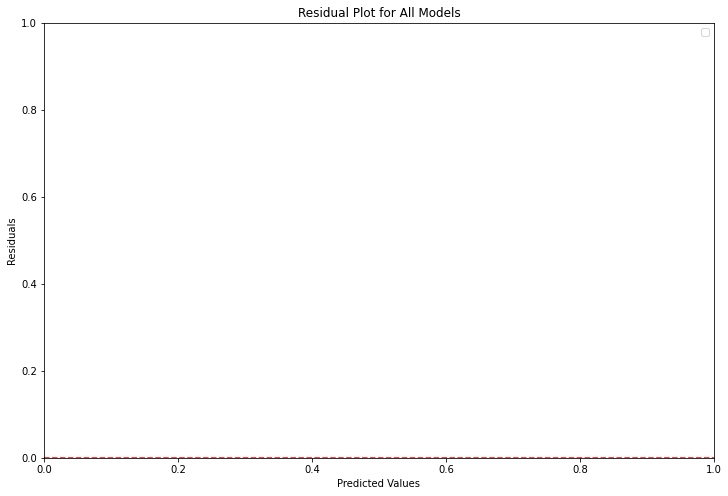

Generating prediction plots...
Error in model Linear Regression: 'Series' object has no attribute 'flatten'
Error in model Ridge Regression: 'Series' object has no attribute 'flatten'


2024-12-05 13:55:06,605 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error in model Lasso Regression: 'Series' object has no attribute 'flatten'
Error in model Random Forest Regressor: 'Series' object has no attribute 'flatten'
Error in model Gradient Boosting Regressor: 'Series' object has no attribute 'flatten'


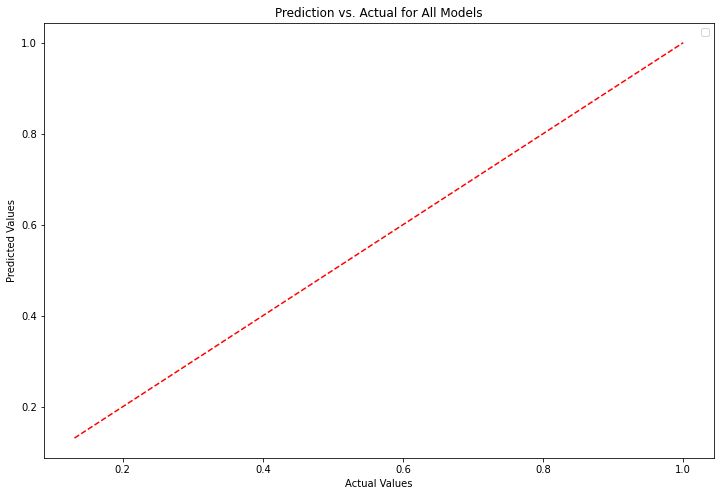

Generating error boxplots...
Error in model Linear Regression: 'Series' object has no attribute 'flatten'
Error in model Ridge Regression: 'Series' object has no attribute 'flatten'
Error in model Lasso Regression: 'Series' object has no attribute 'flatten'
Error in model Random Forest Regressor: 'Series' object has no attribute 'flatten'
Error in model Gradient Boosting Regressor: 'Series' object has no attribute 'flatten'


AttributeError: 'DataFrame' object has no attribute 'iteritems'

<Figure size 864x576 with 0 Axes>

In [9]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(alpha=0.01),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
}

# Initialize results dictionary
results = {}

# Train, evaluate, and collect results
for name, model in models.items():
    print(f"Training and Evaluating {name}...")

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Evaluate the model
    test_loss, y_true, y_pred, metrics = evaluate_shallow_model(
        model, X_test, y_test, calculate_metrics=True
    )

    # Store evaluation results
    results[name] = {
        "Test Loss": test_loss,
        "MSE": metrics["MSE"],
        "MAE": metrics["MAE"],
        "R²": metrics["R²"],
        "Pearson Correlation": metrics["Pearson Correlation"],
    }

# Display results in a DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Generate visualizations
create_visualizations(models=models, X_test=X_test, y_test=y_test)

### 3.2: Unimodal Deep Learning Models

In [ ]:
# Training set
train_tf_dataset = TranscriptomicsDataset(
    X_train, y_train
)
train_trans_loader = DataLoader(train_tf_dataset, batch_size=32, shuffle=True)

# Validation set
val_tf_dataset = TranscriptomicsDataset(
    X_val, y_val
)
val_trans_loader = DataLoader(val_tf_dataset, batch_size=32)

# Test set
test_tf_dataset = TranscriptomicsDataset(
    X_test, y_test
)
test_trans_loader = DataLoader(test_tf_dataset, batch_size=32)

In [ ]:
# Define models
ffnn = FFNN(input_dim=X_train.shape[1], hidden_dim=128, output_dim=1)
cnn = CNN(input_dim=X_train.shape[1], hidden_dim=64, output_dim=1)

# Define loss function and optimizer
criterion = torch.nn.SmoothL1Loss()  # Huber Loss, robust to outliers
ffnn_optimizer = torch.optim.AdamW(ffnn.parameters(), lr=0.001, weight_decay=1e-5)
cnn_optimizer = torch.optim.AdamW(cnn.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate schedulers
ffnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    ffnn_optimizer, mode="min", patience=3, factor=0.5
)
cnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    cnn_optimizer, mode="min", patience=3, factor=0.5
)

# Train FFNN
print("Training FFNN...")
ffnn_train_losses, ffnn_val_losses = train_unimodal_model(
    ffnn,
    train_trans_loader,
    val_trans_loader,
    criterion,
    ffnn_optimizer,
    ffnn_scheduler,
    epochs=50,
    device=device,
    gradient_clipping=1.0,  # Prevent exploding gradients
    early_stopping_patience=5,  # Stop early if no improvement
)

# Train CNN
print("Training CNN...")
cnn_train_losses, cnn_val_losses = train_unimodal_model(
    cnn,
    train_trans_loader,
    val_trans_loader,
    criterion,
    cnn_optimizer,
    cnn_scheduler,
    epochs=50,
    device=device,
    gradient_clipping=1.0,
    early_stopping_patience=5,
)

# Evaluate FFNN
print("Evaluating FFNN...")
ffnn_test_loss, ffnn_y_true, ffnn_y_pred, ffnn_metrics = evaluate_unimodal_model(
    ffnn, test_trans_loader, criterion, device, calculate_metrics=True
)
print(
    f"FFNN Test Loss: {ffnn_test_loss:.4f}, "
    f"MSE: {ffnn_metrics['MSE']:.4f}, "
    f"MAE: {ffnn_metrics['MAE']:.4f}, "
    f"R²: {ffnn_metrics['R²']:.4f}, "
    f"Pearson: {ffnn_metrics['Pearson Correlation']:.4f}"
)

# Evaluate CNN
print("Evaluating CNN...")
cnn_test_loss, cnn_y_true, cnn_y_pred, cnn_metrics = evaluate_unimodal_model(
    cnn, test_trans_loader, criterion, device, calculate_metrics=True
)
print(
    f"CNN Test Loss: {cnn_test_loss:.4f}, "
    f"MSE: {cnn_metrics['MSE']:.4f}, "
    f"MAE: {cnn_metrics['MAE']:.4f}, "
    f"R²: {cnn_metrics['R²']:.4f}, "
    f"Pearson: {cnn_metrics['Pearson Correlation']:.4f}"
)

# # Create visualizations
# create_visualizations(
#     models={"FFNN": ffnn, "CNN": cnn},
#     X_test=X_test,
#     y_test=y_test,
#     train_losses={"FFNN": ffnn_train_losses, "CNN": cnn_train_losses},
#     val_losses={"FFNN": ffnn_val_losses, "CNN": cnn_val_losses},
# )

## Step 3: Multimodal Model Design

#### Separate Feature Extractors:
We will use separate neural networks to extract latent features from each modality:
- **Chemical Data (SMILES):** We will use Graph Neural Networks (GNNs) to process the SMILES representations of chemical compounds. GNNs are well-suited for capturing the structural as well as the hierarchical data information of molecules.
- **Transcriptomics Data:** We will use autoencoders or other neural network architectures to process the TF gene expression data. These models will help in reducing the dimensionality and extracting meaningful features from the high-dimensional gene expression data.

#### Shared Latent Space:
After extracting features from each modality, we will map them to a shared latent space with aligned dimensionality. This shared latent space will allow us to jointly optimize the feature extraction process and the downstream predictive tasks. By aligning the dimensionality, we ensure that the features from different modalities can be effectively combined and compared.

#### Fusion Strategies:
We will explore different fusion strategies to integrate the latent features from each modality:
- **Intermediate Fusion:** In this strategy, we will first learn latent features independently for each modality. Then, we will integrate these features through concatenation or attention layers. This approach allows us to capture the unique characteristics of each modality before combining them for the final prediction.

By following this multimodal approach, we aim to harness the strengths of both chemical and transcriptomics data, leading to more accurate and reliable predictions in our downstream tasks.

![Multimodal schema](https://blog.roboflow.com/content/images/2024/04/image-1203.webp)

In [ ]:
featurizer = MolGraphConvFeaturizer()

# Training set
train_chem_dataset = MoleculeDataset(
    smiles_list = train_chem_df.values.flatten().tolist())
train_chem_dataset.add_graphs(featurizer)
logging.info(f"Finished adding graphs: {len(train_chem_dataset.graphs_list)}")

# Validation set
val_chem_dataset = MoleculeDataset(smiles_list = val_chem_df.values.flatten().tolist())
val_chem_dataset.add_graphs(featurizer)

# Test set
test_chem_dataset = MoleculeDataset(smiles_list = test_chem_df.values.flatten().tolist())
test_chem_dataset.add_graphs(featurizer)

In [ ]:
test_chem_loader = GeometricDataLoader(test_chem_dataset.graphs_list, batch_size=32)
val_chem_loader = GeometricDataLoader(val_chem_dataset.graphs_list, batch_size=32)
train_chem_loader = GeometricDataLoader(
    train_chem_dataset.graphs_list, batch_size=32, shuffle=True
)

In [ ]:
# Training set
train_combined_dataset = MultimodalDataset(train_chem_dataset, train_trans_dataset)
train_combined_loader = DataLoader(train_combined_dataset, batch_size=32, shuffle=True)

# Validation set
val_combined_dataset = MultimodalDataset(val_chem_dataset, val_trans_dataset)
val_combined_loader = DataLoader(val_combined_dataset, batch_size=32)

# Test set
test_combined_dataset = MultimodalDataset(test_chem_dataset, test_trans_dataset)
test_combined_loader = DataLoader(test_combined_dataset, batch_size=32)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define chemical model
chem_model = GNN(
    num_node_features=15,  
    num_edge_features=13,  
    hidden_dim=64,
    output_dim=128,
    dropout=0.1,
).to(device)

# Define transcriptomics model
trans_model = TranscriptomicsNN(
    input_dim=train_transcriptomics_df.shape[1],
    hidden_dim=512,
    output_dim=128,
    dropout=0.1,
).to(device)

# Define multimodal model
multimodal_model = MultimodalNN(
    chem_output_dim=128,
    trans_output_dim=128,
    hidden_dim=256,
    output_dim=1,
    dropout=0.1,
).to(device)

# Optimizer and loss function
optimizer = torch.optim.Adam(
    list(chem_model.parameters())
    + list(trans_model.parameters())
    + list(multimodal_model.parameters()),
    lr=0.001,
)

criterion = torch.nn.MSELoss()

In [ ]:
# Train the model
from training.train_multimodal import evaluate_multimodal_model


train_losses, val_losses = train_multimodal_model(
    chem_model,
    trans_model,
    multimodal_model,
    train_chem_loader,
    train_trans_loader,
    val_chem_loader,
    val_trans_loader,
    optimizer,
    criterion,
    device=device,
    epochs=20, 
)

# Evaluate on test data
test_loss, y_true, y_pred, metrics = evaluate_multimodal_model(
    chem_model,
    trans_model,
    multimodal_model,
    test_chem_loader,
    test_trans_loader,
    criterion,
    device,
)

# Display evaluation metrics
print(
    f"Test Loss: {test_loss:.4f}, "
    f"MSE: {metrics['MSE']:.4f}, "
    f"MAE: {metrics['MAE']:.4f}, "
    f"R²: {metrics['R²']:.4f}, "
    f"Pearson: {metrics['Pearson Correlation']:.4f}"
)

In [ ]:
# Prepare the models dictionary for visualization
models = {
    "Multimodal Model": multimodal_model,
}

# Add train and validation losses to match the visualization structure
train_losses_dict = {"Multimodal Model": train_losses}
val_losses_dict = {"Multimodal Model": val_losses}

# Call the unified visualization function
# create_visualizations(
#     models=models,
#     X_test=None,
#     y_test=y_test,
#     train_losses=train_losses_dict,
#     val_losses=val_losses_dict,
# )

In [ ]:
print(
    f"Test Loss: {test_loss:.4f}, "
    f"MSE: {metrics['MSE']:.4f}, "
    f"MAE: {metrics['MAE']:.4f}, "
    f"R²: {metrics['R²']:.4f}, "
    f"Pearson: {metrics['Pearson Correlation']:.4f}"
)